# RNN [Recurrent Neural Network]
- A Recurrent Neural Network (RNN) is a type of deep learning model designed to work with sequence data — data where order matters.
- Unlike normal neural networks, an RNN remembers past information and uses it to make current predictions.
#### LSTM (Long Short Term Memory)
- LSTM is a special type of RNN designed to remember information for a long time and avoid the vanishing gradient problem.
- It uses gates to control what to remember, forget, and output.
#### GRU (Gated Recurrent Unit)
- GRU is a simpler and faster version of LSTM.
- It has fewer gates but performs almost as well.

In [1]:
# Load th Libraries

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load The Dataset
data = pd.read_csv('monthly_milk_production.csv')
data.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [4]:
# Feature Engineering (changing Index, set time_date, changing column names)

data.columns = ['Month', 'Milk_Production']
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

data.head()

,Milk_Production
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Milk_Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


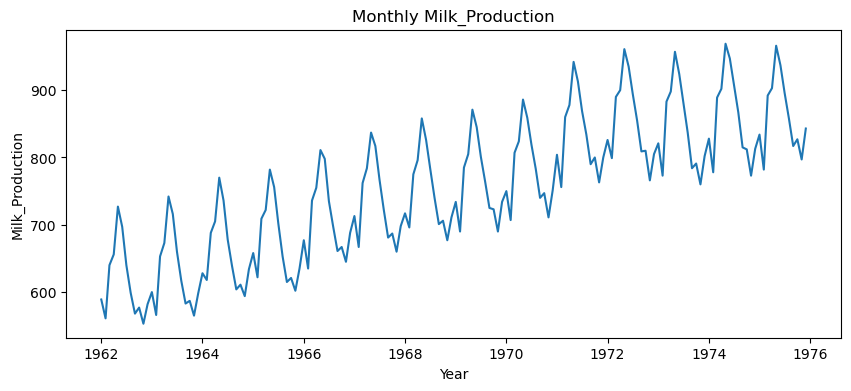

In [6]:
# Plot for Milk_Production
plt.figure(figsize=(10,4))
plt.plot(data)
plt.title("Monthly Milk_Production")
plt.xlabel("Year")
plt.ylabel("Milk_Production")
plt.show()

In [7]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data.shape

(168, 1)

In [8]:
# Create Sliding Window

window = 12
values = scaled_data.flatten()        #flatten - Converts 2D array → 1D array

X = []
y = []

for i in range(window, len(values)):
    X.append(values[i-window:i])
    y.append(values[i])

X = np.array(X).reshape(-1, window, 1)
y = np.array(y)

In [9]:
# TRAIN-TEST SPLIT (80% TRAIN)

split = int(len(X) * 0.80)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [10]:
# MODEL BUILDER
# Select RNN / LSTM / GRU

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU


def build_model(model_type, units=32):
    model = Sequential()

    if model_type == "RNN":
        model.add(SimpleRNN(units, input_shape=(window,1)))
    elif model_type == "LSTM":
        model.add(LSTM(units, input_shape=(window,1)))
    elif model_type == "GRU":
        model.add(GRU(units, input_shape=(window,1)))
    else:
        raise valueError('Invalid Model Type')

    model.add(Dense(1))
    model.compile(optimizer = "adam", loss='mse')
    
    return model

In [11]:
models = {"RNN": build_model("RNN"),
        "LSTM": build_model("LSTM"),
        "GRU": build_model("GRU")}

In [12]:
# TRAIN ALL MODELS
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train,
              epochs=40,
              batch_size=16,
              verbose=0)

Training RNN...
Training LSTM...
Training GRU...


In [13]:
# EVALUATION METRICS

from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae  = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mae, mape


In [14]:
# EVALUATE ALL MODELS

results = []
y_actual = scaler.inverse_transform(y_test.reshape(-1,1))

for name, model in models.items():

    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds)

    rmse, mae, mape = evaluate(y_actual, preds)
    results.append([name, rmse, mae, mape])

# Show results
results_df = pd.DataFrame(
    results, columns=["Model", "RMSE", "MAE", "MAPE"]
)
print("<--- Model Comparison --->")
print(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
<--- Model Comparison --->
  Model       RMSE        MAE      MAPE
0   RNN  20.022523  16.411572  1.930350
1  LSTM  55.463173  48.223930  5.738476
2   GRU  45.388411  34.479391  3.972781


In [15]:
# SELECT BEST MODEL

best = results_df.sort_values("RMSE").iloc[0]["Model"]
best_model = models[best]

print(" Best Model =", best)

 Best Model = RNN


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


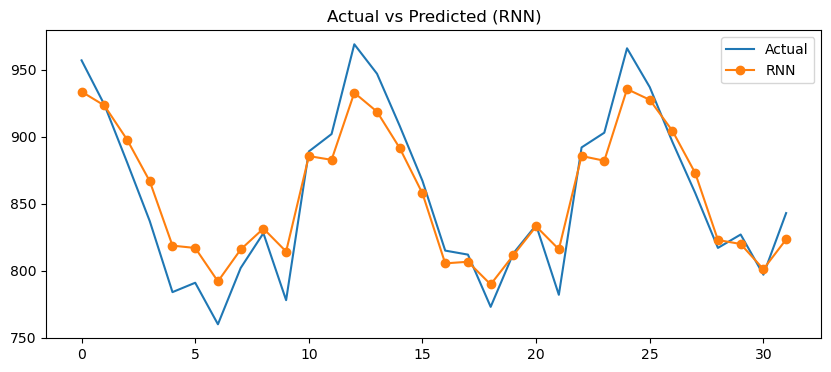

In [16]:
# PLOT Best Model Predictions

best_preds = best_model.predict(X_test)
best_preds = scaler.inverse_transform(best_preds)

plt.figure(figsize=(10,4))
plt.plot(y_actual, label="Actual")
plt.plot(best_preds, label=best, marker="o")
plt.title(f"Actual vs Predicted ({best})")
plt.legend()
plt.show()

In [17]:
# FORECAST NEXT 12 MONTHS

future_steps = 12
last_window = X_test[-1]         # Last available input sequence

future = []

for _ in range(future_steps):
    next_val = best_model.predict(last_window.reshape(1,window,1))[0,0]
    future.append(next_val)

    # Slide window → add new prediction
    last_window = np.roll(last_window, -1)
    last_window[-1] = next_val


future = scaler.inverse_transform(np.array(future).reshape(-1,1))

future_dates = pd.date_range(
    start=data.index[-1], periods=future_steps+1, freq="M"
)[1:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


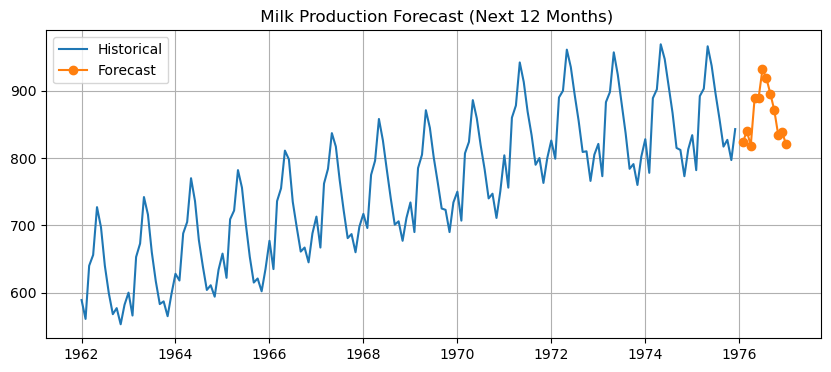

In [18]:
plt.figure(figsize=(10,4))
plt.plot(data, label="Historical")
plt.plot(future_dates, future, label="Forecast", marker="o")
plt.title(" Milk Production Forecast (Next 12 Months)")
plt.legend()
plt.grid(True)
plt.show()

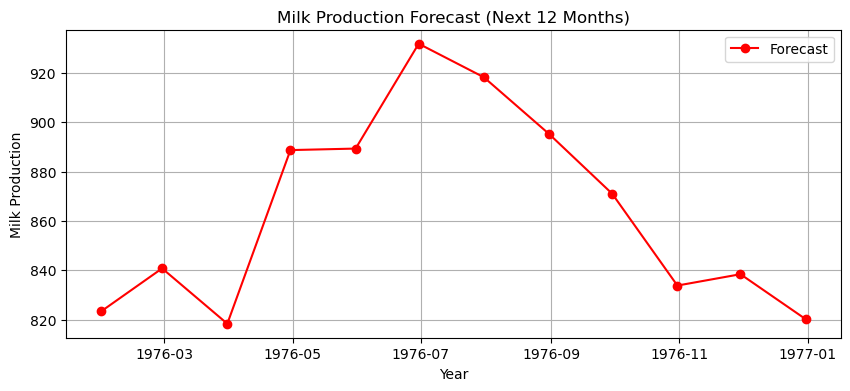

In [19]:
# Milk Production Forecast (Next 12 Months)

plt.figure(figsize=(10,4))
plt.plot(future_dates, future, marker='o', color='red', label='Forecast')

plt.title("Milk Production Forecast (Next 12 Months)")
plt.xlabel("Year")
plt.ylabel("Milk Production")
plt.legend()
plt.grid(True)
plt.show()


### Final Result:

In [20]:
# Feature Forecast 

forecast_df = pd.DataFrame({
    "Month": future_dates,
    "Forecast": future.flatten()
})

print("Future Forecast (Next 12 Months):")
print(forecast_df)

Future Forecast (Next 12 Months):
        Month    Forecast
0  1976-01-31  823.345398
1  1976-02-29  840.766785
2  1976-03-31  818.341614
3  1976-04-30  888.703735
4  1976-05-31  889.316772
5  1976-06-30  931.808167
6  1976-07-31  918.210571
7  1976-08-31  895.220886
8  1976-09-30  871.018250
9  1976-10-31  833.807800
10 1976-11-30  838.405884
11 1976-12-31  820.189209
